<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset["train"]["text"]):
    sentences.extend([sentence.lower() for sentence in sent_tokenize(text) if len(sentence.split()) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 219930


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

# Расчет встречаемости слов
for sent in tqdm(sentences):
    for word in word_tokenize(sent):
        words[word] += 1
# Расчет встречаемости слов

  0%|          | 0/219930 [00:00<?, ?it/s]

In [ ]:
print(len(words))

77793


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 20000

for word, cnt in tqdm(words.most_common(vocab_size)):
      vocab.add(word)


# Наполнение словаря

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 20004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)# Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, epochs):
    model.to(device)
    losses = []
    perplexities = []

    for epoch in range(epochs):
        epoch_losses = []
        model.train()

        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}'):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)

            logits = model(input_ids).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, target_ids.flatten())

            loss.backward()
            optimizer.step()

            epoch_losses.append(torch.exp(loss).item())


        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, test_dataloader))

        print(f'Loss: {losses[-1]}; Perplexities: {perplexities[-1]}')

    return losses, perplexities


In [ ]:
torch.cuda.empty_cache()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageGRUModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.gru(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))

        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
# Обучите модель здесь
model_gru = LanguageGRUModel(hidden_dim=256, vocab_size=len(vocab))
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_gru.parameters())

losses_gru, perplex_gru = train_model(model_gru, train_dataloader, test_dataloader, criterion, optimizer, 10)


Training epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 278.95401132479583; Perplexities: 103.56294305490893


Training epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 96.83426453746449; Perplexities: 81.24789068532544


Training epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 80.69639271684126; Perplexities: 71.50476288462794


Training epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 71.95056512728604; Perplexities: 65.80942251959513


Training epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 66.00259984796698; Perplexities: 62.05064930139586


Training epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 61.559554512717504; Perplexities: 59.206016456249145


Training epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 58.01891081099077; Perplexities: 57.032948023773905


Training epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 55.08496212491122; Perplexities: 55.28530356384987


Training epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 52.592694441361864; Perplexities: 53.88931387967842


Training epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 50.477758320201524; Perplexities: 52.80163071210994


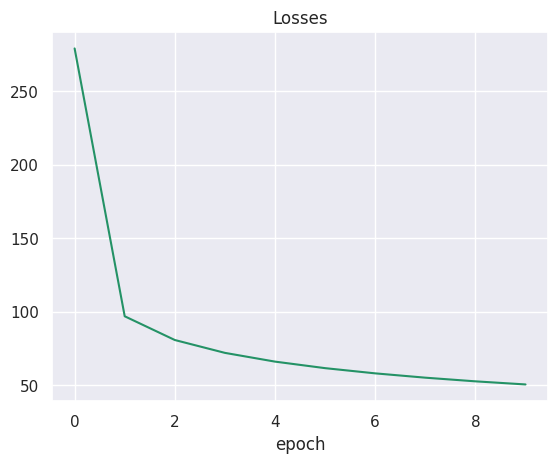

In [ ]:
plt.plot(np.arange(len(losses_gru)), losses_gru)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

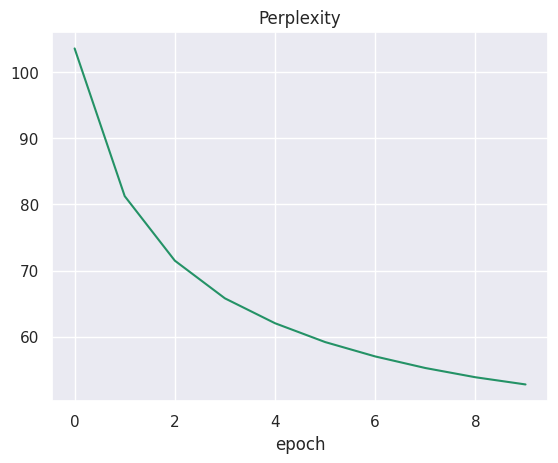

In [ ]:
plt.plot(np.arange(len(perplex_gru)), perplex_gru)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
# Проведите второй эксперимент
class LanguageLSTMModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))

        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
# Обучите модель здесь
model_lstm = LanguageLSTMModel(hidden_dim=256, vocab_size=len(vocab))
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_lstm.parameters())

losses_lstm, perplex_lstm = train_model(model_lstm, train_dataloader, eval_dataloader, criterion, optimizer, 10)

Training epoch 1:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 303.25739964710584; Perplexities: 103.97326624670694


Training epoch 2:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 96.23812114368785; Perplexities: 81.06348298982132


Training epoch 3:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 79.84407550881126; Perplexities: 70.77159736544587


Training epoch 4:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 70.74236553400213; Perplexities: 64.5542307343594


Training epoch 5:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 64.55051146351208; Perplexities: 60.25217982447425


Training epoch 6:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 59.858812907825815; Perplexities: 57.13089634207792


Training epoch 7:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 56.11642964588512; Perplexities: 54.59219750692678


Training epoch 8:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 52.932841291947796; Perplexities: 52.57416176906852


Training epoch 9:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 50.23300387573242; Perplexities: 50.778786397534745


Training epoch 10:   0%|          | 0/1375 [00:00<?, ?it/s]

Loss: 47.84572925359553; Perplexities: 49.337468457776446


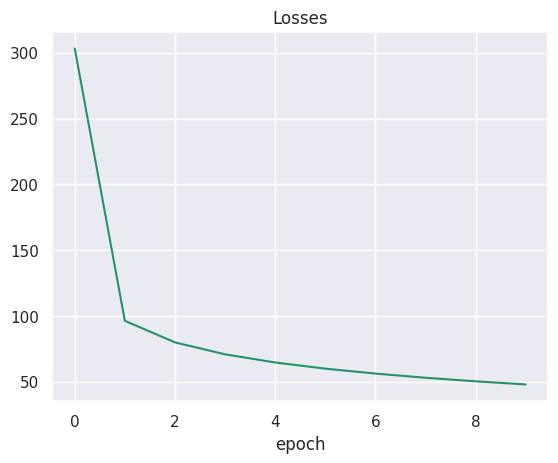

In [ ]:
plt.plot(np.arange(len(losses_lstm)), losses_lstm)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

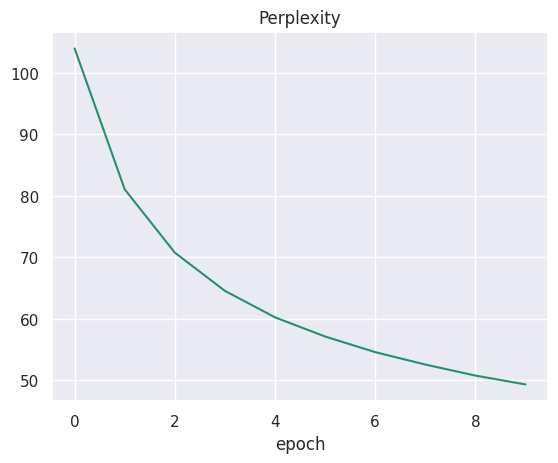

In [ ]:
plt.plot(np.arange(len(perplex_lstm)), perplex_lstm)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [ ]:
data = {
    'loss - gru': losses_gru,
    'loss - lstm': losses_lstm,
    'perplexity - gru': perplex_gru,
    'perplexity - lstm': perplex_lstm
}
df = pd.DataFrame(data)
df

,loss - gru,loss - lstm,perplexity - gru,perplexity - lstm
0,278.954011,303.257400,103.562943,103.973266
1,96.834265,96.238121,81.247891,81.063483
2,80.696393,79.844076,71.504763,70.771597
3,71.950565,70.742366,65.809423,64.554231
4,66.002600,64.550511,62.050649,60.252180
5,61.559555,59.858813,59.206016,57.130896
6,58.018911,56.116430,57.032948,54.592198
7,55.084962,52.932841,55.285304,52.574162
8,52.592694,50.233004,53.889314,50.778786
9,50.477758,47.845729,52.801631,49.337468


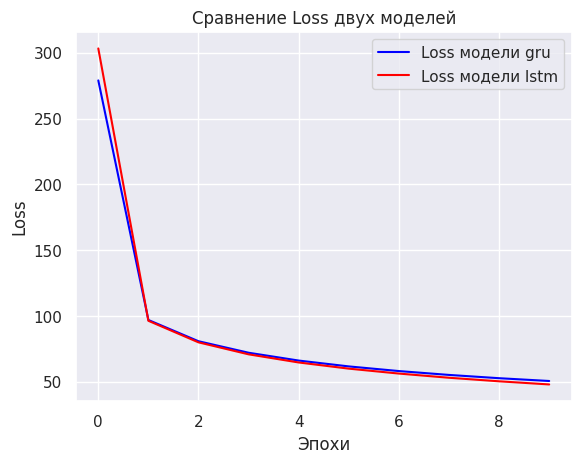

In [ ]:
plt.plot(losses_gru, label='Loss модели gru', color='blue')
plt.plot(losses_lstm, label='Loss модели lstm', color='red')

plt.title('Сравнение Loss двух моделей')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

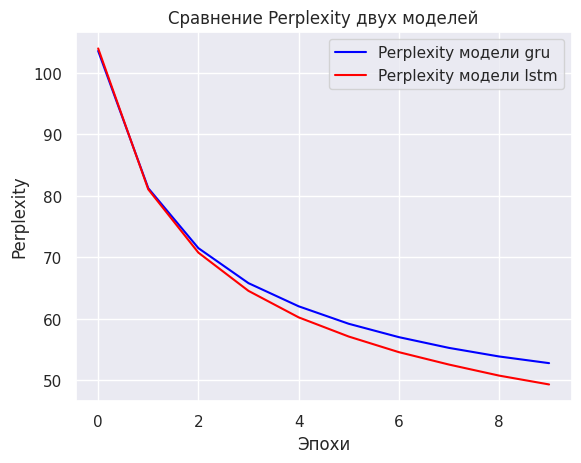

In [ ]:
plt.plot(perplex_gru, label='Perplexity модели gru', color='blue')
plt.plot(perplex_lstm, label='Perplexity модели lstm', color='red')

plt.title('Сравнение Perplexity двух моделей')
plt.xlabel('Эпохи')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.show()

#Отчет
В данном ноутбке было проведено 2 эксперимента. Были обучены и протестированы две модели: GRU и LSTM

Данные:
vocab_size = 20004

epochs = 10

batch_size = 128

hidden_dim=256

criterion = nn.CrossEntropyLoss

optimizer = torch.optim.Adam


## Модель GRU
Возьмем базовую архитектуру модели на RNN и переведем ее на GRU. После обучим ее на train_dataloader и выведем результат на eval_dataloader.
После обучения увидим, что итоговыми резльтутами для модели стали:

loss_gru: 50.477758

perplex_gru: 52.801631

## Модель LSTM
Поменяем слой GRU на LSTM и также обучим. Получим такой итог:

loss_lstm: 47.845729

perplex_lstm: 49.337468

## Вывод

Анализируя данные можно увидеть, что LSTM выдала результат перплексии явно лучше, чем GRU, что для меня стало неожиданность. Вполне может быть, что мало данных, но я взял размер 20004 из соображений, что при больших данных используется слишком много кеша CUDA из-за чего обучение не запускается.

В данных экспериментах LSTM оказалась лучше.